In [83]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Note to change "prepare phoenix" to use the lyon models

In [2]:
from urllib.request import urlretrieve, urlopen

In [45]:
def lyon_phxurl(Teff, logg=4.5, repo='ftp'):
    """
    Constructs the URL for the phoenix spectrum file for a star with effective
    temperature Teff, log surface gravity logg, metalicity FeH, and alpha
    elemnt abundance aM.

    Does not check that the URL is actually valid, and digits beyond the
    precision of the numbers used in the path will be truncated.
    """
    phoenixbaseurl = 'https://phoenix.ens-lyon.fr/Grids/BT-Settl/CIFIST2011_2015/SPECTRA/'
  
    name = 'lte{T:05.1f}-{g:3.1f}-0.0a+0.0.BT-Settl.spec.7.xz'.format(T=Teff/100.0, g=logg)
    print(name)

    if repo == 'ftp':
        #folder = 'Z' + zstr + astr + '/'
        return phoenixbaseurl + name
    else:
        return os.path.join(repo, name)

def fetchphxfile(Teff, logg, FeH=0.0, aM=0.0, repo='r', source = 'lyon'):
    if source == 'lyon':
        loc, ftp = [lyon_phxurl(Teff, logg, repo=r) for r in [repo, 'ftp']]
    urlretrieve(ftp, loc)

In [50]:
#check it works as is
repo = 'test_repo/'
#fetchphxfile(2500, 5.0, 0.0, 0.0, repo)
#good

In [43]:
#lte025.0-5.0-0.0a+0.0.BT-Settl.spec.7.xz
Teff = 2500.
logg = 5.0
name = 'lte{T:05.1f}-{g:3.1f}-0.0a+0.0.BT-Settl.spec.7.xz'.format(T=Teff/100.0, g=logg)
name

'lte025.0-5.0-0.0a+0.0.BT-Settl.spec.7.xz'

In [48]:
fetchphxfile(2500, 5.0, 0.0, 0.0, repo='test_repo/')
#lte025.0-5.0-0.0a+0.0.BT-Settl.spec.7.xz

lte025.0-5.0-0.0a+0.0.BT-Settl.spec.7.xz
lte025.0-5.0-0.0a+0.0.BT-Settl.spec.7.xz


In [47]:
import lzma

In [72]:
#spec = lzma.open(repo+name,mode='rt', encoding='utf-8')#
nameout = name[:-3]
print(nameout)
with lzma.open(repo+name) as f, open(repo+nameout, 'wb') as fout: #https://stackoverflow.com/a/33718185
    file_content = f.read()
    fout.write(file_content)

lte025.0-5.0-0.0a+0.0.BT-Settl.spec.7


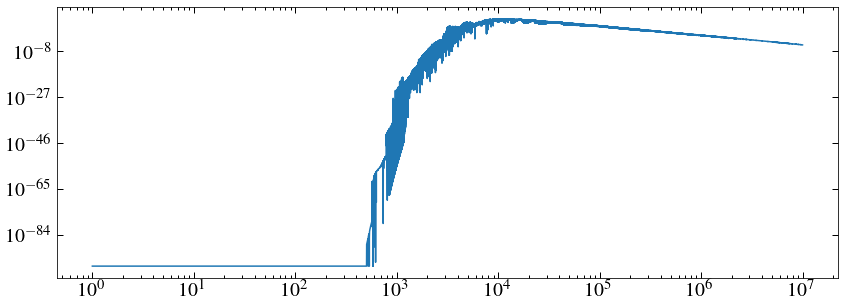

In [84]:
wavemin=2000, # in angstroms
wavemax=55000
DF = -8.

ts = [2700.0, 2700.0, 2600.0, 2600.0]
gs = [5.0, 5.5, 5.5, 5.0]
waves = []
fluxes = []
spectra = []
npSpectra = [repo+nameout]

for i, sp in enumerate(npSpectra):
    #params = {'Teff':ts[i], 'logg':gs[i], 'FeH':0.0, 'aM':0.0}
    phoenixR = ascii.read(sp,format="fixed_width_no_header",col_starts=(0,14),col_ends=(12,25),delimiter=" ",names=('Wave','Spec'))
    #print(len(phoenixR['Wave']))
    ph1, jj = np.unique(np.array(phoenixR['Wave']),return_index=True)
    phoenix = np.zeros((len(ph1),2))
    for kk in range(len(jj)):
        phoenix[kk,1] = np.float64(phoenixR['Spec'][jj[kk]].replace("D","E"))
    phoenix[:,0] = ph1
    ind = np.where( (phoenix[:,0] <= wavemax) & (phoenix[:,0] >= wavemin))[0]  
    xraw = phoenix[:,0]
    yraw = np.power(10.,phoenix[:,1] + DF)#.tolist()
    waves.append(xraw)
    fluxes.append(yraw)
   # params.update({'flux':yraw})
   # spectra.append(params)
   # print(len(params['flux']))
    #plt.plot(xraw, params['flux'])
plt.plot(waves[0], fluxes[0])
plt.xscale('log')
plt.yscale('log')
#ascii.write(Table([waves[0], fluxes[0]]), repo+'test_small.txt', overwrite=True)

Can we expand up to 27000? What's the file size difference? Only a few MB in it, let's do it!